In [1]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset

#from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
#from visualization_functions import *
import numpy as np
from processing_functions import *
import pandas as pd
import dask
import dask.array as da
import warnings
from net_cdf_functions import *
# %matplotlib inline
# import dask
from dask.distributed import Client

# check if port is already in use

# client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")
# client

#data_path = "/media/thom/Q/data/"
#data_path = 'data/test/'
data_path = 'data/'


# fetch and save data 2000-2020
check_and_download_missing_files("2000-01-01", data_path)

Missing file for data/PRISM\2024\PRISM_temp_20241025.nc
Missing file for data/PRISM\2024\PRISM_temp_20241026.nc
Missing file for data/PRISM\2024\PRISM_temp_20241027.nc
Missing file for data/PRISM\2024\PRISM_temp_20241028.nc
Total missing files to download: 4
Error downloading data for 2024-10-25 2024: 503 Service Unavailable
TDS Server-unavailable!
skipping update
Number of files modified: 0


In [ ]:
client = Client(n_workers=18, threads_per_worker=1, memory_limit=0)
client

<Client: 'tcp://127.0.0.1:57740' processes=18 threads=18>

2024-10-24 01:46:43,842 - distributed.scheduler - WARNING - Worker failed to heartbeat for 7521s; attempting restart: <WorkerState 'tcp://127.0.0.1:57837', name: 13, status: running, memory: 0, processing: 0>
2024-10-24 01:46:43,846 - distributed.scheduler - WARNING - Worker failed to heartbeat for 7521s; attempting restart: <WorkerState 'tcp://127.0.0.1:57838', name: 12, status: running, memory: 0, processing: 0>
2024-10-24 01:46:46,664 - distributed.nanny - WARNING - Restarting worker
2024-10-24 01:46:46,675 - distributed.nanny - WARNING - Restarting worker
2024-10-24 09:58:37,962 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-24 09:58:37,973 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


def calculate_maturation_date(dd_data, start_date, threshold, generations):
    print(type(start_date))
    """
    Calculate the date when the threshold is reached for the specified number of generations
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )

    for _ in range(generations - 1):
        threshold_reached_days = compute_dd_threshold_reached_dates(
            dd_data, threshold_reached_days, threshold
        )

    # Return an xarray with the date when the threshold is reached for the last time as one value and also the timedelta from the start date
    return threshold_reached_days

In [12]:
from glob import glob
def read_netcdfs(files, dim, lat, lon, LTT, UTT):
    #this method is faster for 1x1 degree data

    def process_one_path(path):
        # Use a context manager to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # Crop the dataset
            ds = ds.sel(latitude=lat, longitude=lon, method="nearest")
            # Calculate degree days
            ds["degree_days"] = single_sine_horizontal_cutoff(
            ds["tmin"], ds['tmax'], LTT, UTT
        )
            #select only degree
            ds = ds.drop_vars(["tmin", "tmax"])
            # Load all data from the transformed dataset to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    # Get a sorted list of file paths
    paths = sorted(glob(files))
    # Process each file and store the datasets in a list
    datasets = [process_one_path(p) for p in paths]
    # Concatenate all datasets along the specified dimension
    combined = xr.concat(datasets, dim)
    return combined

# Example usage

DD_Data = read_netcdfs( files = data_path + "PRISM/*/PRISM_temp_*.nc", dim='t', lat = 34.05 , lon = -118.25, LTT = 9.4, UTT = 999)

In [2]:
import xarray as xr
from glob import glob

def read_netcdfs(files, points, LTT, UTT):
    def process_one_path(path):
        # Use a context manager to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # Initialize an empty list to store data for each point
            point_datasets = []
            for lat, lon in points:
                # Select data for the current point
                ds_point = ds.sel(latitude=lat, longitude=lon, method="nearest")
                # Calculate degree days
                ds_point["degree_days"] = single_sine_horizontal_cutoff(
                    ds_point["tmin"], ds_point['tmax'], LTT, UTT
                )
                # Select only degree days
                ds_point = ds_point.drop_vars(["tmin", "tmax"])
                # Load all data from the transformed dataset to ensure we can
                # use it after closing each original file
                ds_point.load()
                # Append the processed dataset for the current point
                point_datasets.append(ds_point)
            # Concatenate data for all points along a new dimension 'point'
            ds_combined = xr.concat(point_datasets, dim='point')
            return ds_combined

    # Get a sorted list of file paths
    paths = sorted(glob(files))
    # Process each file and store the datasets in a list
    datasets = [process_one_path(p) for p in paths]
    # Concatenate all datasets along the specified dimension
    combined = xr.concat(datasets, 't')
    return combined

# Example usage
points = [(34.05, -118.25),
         (36.77, -119.41)]  # Replace with your list of (latitude, longitude) tuples
combined = read_netcdfs(files = data_path + "PRISM/*/PRISM_temp_*.nc", points=points, LTT=10, UTT=30)

In [3]:
combined

<xarray.Dataset> Size: 218kB
Dimensions:      (point: 2, t: 9064)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
    longitude    (point) float64 16B -118.2 -119.4
    latitude     (point) float64 16B 34.04 36.75
Dimensions without coordinates: point
Data variables:
    degree_days  (point, t) float64 145kB 0.8267 1.225 2.172 ... 9.671 9.66
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [31]:
DD_Data
#add variable day of year to the dataset
DD_Data['day_of_year'] = DD_Data.indexes['t'].dayofyear
#drop data from february 29th

#create mod_1_data that aggregates the data by day of year and calculates the mean
mod_1_data = DD_Data.groupby('day_of_year').mean('t')


#write a function that iterates through mod_1_data_dd from a given start position and calculates a cumsum until a threshold is reached. If the end of the array is reached, the function should start over from the beginning of the array and keep counting. The function should return the number of elapsed days until the threshold is reached as an int. 
def mod_1_cumsum(data, start, threshold):
    #initialize variables
    cumsum = 0
    elapsed_days = 0
    #iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        #add the value of the current position to the cumsum
        cumsum += data[i]
        #increment the elapsed days
        elapsed_days += 1
        #if the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days
    #if the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    return elapsed_days

In [33]:
mod_1_data_dd = mod_1_data['degree_days'].values

In [17]:
test = mod_1_cumsum(mod_1_data_dd, 0, 450)

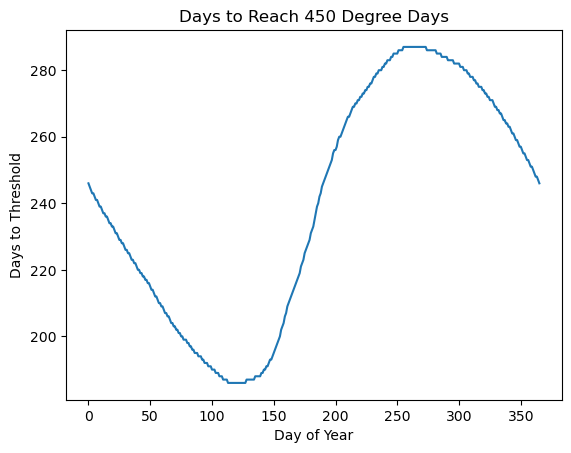

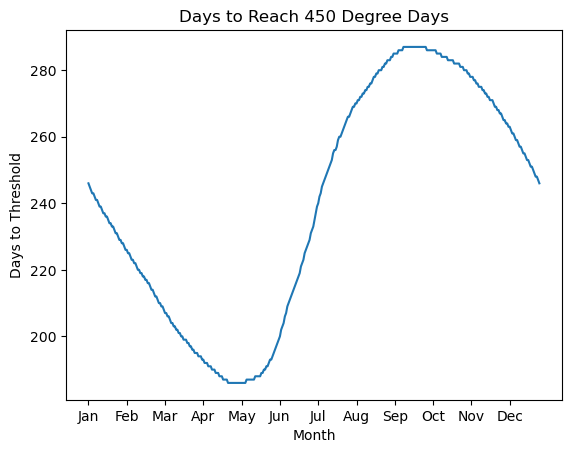

In [53]:
#run mod_1_cumsum for all days of the year and store the results in a dataframe
results = []
for i in range(0, 366):
    results.append(mod_1_cumsum(mod_1_data_dd, i, 754*3))
results_df = pd.DataFrame(results)
results_df.columns = ['days_to_threshold_mod_1']
results_df['day_of_year'] = range(1, 367)
#add dates to the dataframe
results_df['date'] = pd.to_datetime(results_df['day_of_year'], format='%j')
results_df['date'] = results_df['date'].dt.strftime('%m-%d')
results_df['date'] = '2020-' + results_df['date']
#plot the results
import matplotlib.pyplot as plt
plt.plot(results_df['days_to_threshold_mod_1'])
plt.xlabel('Day of Year')
plt.ylabel('Days to Threshold')
plt.title('Days to Reach 450 Degree Days')
plt.show()

#plot the results with month labels
import matplotlib.pyplot as plt
plt.plot(results_df['days_to_threshold_mod_1'])
plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Days to Threshold')
plt.title('Days to Reach 450 Degree Days')
plt.show()


In [38]:
results_df

days_to_threshold_mod_1  day_of_year        date
0                        246            1  2020-01-01
1                        245            2  2020-01-02
2                        244            3  2020-01-03
3                        243            4  2020-01-04
4                        243            5  2020-01-05
..                       ...          ...         ...
361                      249          362  2020-12-28
362                      248          363  2020-12-29
363                      248          364  2020-12-30
364                      247          365  2020-12-31
365                      246          366  2020-01-01

[366 rows x 3 columns]

In [54]:
############# model 2 1 year test
#for each day in the year calculate the cumulative sum of degree days until the threshold is reached and store the number of days in a dataframe. 

mod_2_raw = [] 
mod_2_mean = []
mod_2_std = []
mod_2_median = []
mod_2_max = []
mod_2_min = []
mod_2_range = []

for i in range(0, 366):
    date = '2023-' + str(i+1).zfill(3)
    date = pd.to_datetime(date, format='%Y-%j')
    date = date.strftime('%Y-%m-%d')
    data = fflies_model_run(date, DD_Data['degree_days'], 34.05, -118.25, LTT = 9.4, UTT = 999, dd_threshold=754, use_current_years_weather= False)
    data = data['timedelta'].values.tolist()
    mod_2_raw.append(data)
    mod_2_mean.append(np.mean(data))
    mod_2_std.append(np.std(data))
    mod_2_median.append(np.median(data))
    mod_2_max.append(np.max(data))
    mod_2_min.append(np.min(data))
    mod_2_range.append(np.max(data) - np.min(data))

results_df['mod_2_raw'] = mod_2_raw
results_df['mod_2_mean'] = mod_2_mean
results_df['mod_2_std'] = mod_2_std
results_df['mod_2_median'] = mod_2_median
results_df['mod_2_max'] = mod_2_max
results_df['mod_2_min'] = mod_2_min
results_df['mod_2_range'] = mod_2_range



running DD accumulations for historical data, 20 yrs
2000-01-01
2000-01-01
<class 'numpy.datetime64'>
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-05-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
f1 date:  <xarray.DataArray 'gen_comp_date' ()> Size: 8B
array('2000-05-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-07-11T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-09-03T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
2001-01-01
2001-01-01
<class 'numpy.datetime64'>
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2001-05-22T00:00:00.000000000', dtype='da

In [55]:
results_df

days_to_threshold_mod_1  day_of_year        date  \
0                        246            1  2020-01-01   
1                        245            2  2020-01-02   
2                        244            3  2020-01-03   
3                        243            4  2020-01-04   
4                        243            5  2020-01-05   
..                       ...          ...         ...   
361                      249          362  2020-12-28   
362                      248          363  2020-12-29   
363                      248          364  2020-12-30   
364                      247          365  2020-12-31   
365                      246          366  2020-01-01   

                                             mod_2_raw  mod_2_mean  mod_2_std  \
0    [246, 265, 262, 244, 242, 252, 241, 243, 243, ...      243.95  11.625296   
1    [245, 265, 262, 243, 243, 251, 240, 242, 243, ...      243.25  11.695619   
2    [244, 264, 262, 243, 242, 250, 240, 241, 243, ...      242.65  11.637332   
3    [243, 264, 261, 242, 241, 249, 239, 241, 242, ...      241.95  11.672510   
4    [243, 264, 260, 243, 240, 248, 238, 241, 242, ...      241.30  11.802966   
..                                                 ...         ...        ...   
361  [267, 265, 247, 246, 253, 243, 247, 247, 246, ...      246.10  11.695726   
362  [266, 264, 247, 245, 254, 243, 246, 246, 246, ...      245.50  11.642594   
363  [266, 264, 246, 244, 253, 242, 245, 245, 245, ...      244.80  11.732860   
364  [266, 263, 245, 243, 253, 241, 244, 244, 244, ...      244.10  11.966202   
365  [246, 265, 262, 244, 242, 252, 241, 243, 243, ...      243.95  11.625296   

     mod_2_median  mod_2_max  mod_2_min  mod_2_range  
0           243.5        265        223           42  
1           243.0        265        223           42  
2           243.0        264        222           42  
3           242.0        264        221           43  
4           241.5        264        220           44  
..            ...        ...        ...          ...  
361         246.5        267        226           41  
362         246.0        266        226           40  
363         245.0        266        225           41  
364         244.0        266        224           42  
365         243.5        265        223           42  

[366 rows x 10 columns]

In [22]:
test = fflies_model_run("2023-04-01", DD_Data['degree_days'], 34.05, -118.25, LTT = 9.4, UTT = 999, dd_threshold=754, use_current_years_weather= False)
test

running DD accumulations for historical data, 20 yrs
2000-04-01
2000-04-01
<class 'numpy.datetime64'>
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-06-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
f1 date:  <xarray.DataArray 'gen_comp_date' ()> Size: 8B
array('2000-06-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-08-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-10-11T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
2001-04-01
2001-04-01
<class 'numpy.datetime64'>
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2001-06-24T00:00:00.000000000', dtype='da

<xarray.Dataset> Size: 336B
Dimensions:        (t: 20)
Coordinates:
    longitude      float64 8B -118.2
    latitude       float64 8B 34.04
  * t              (t) int32 80B 2000 2001 2002 2003 ... 2016 2017 2018 2019
Data variables:
    gen_comp_date  (t) datetime64[ns] 160B 2000-10-11 2001-10-25 ... 2019-10-08
    timedelta      (t) int32 80B 193 207 224 202 189 207 ... 179 185 178 180 190

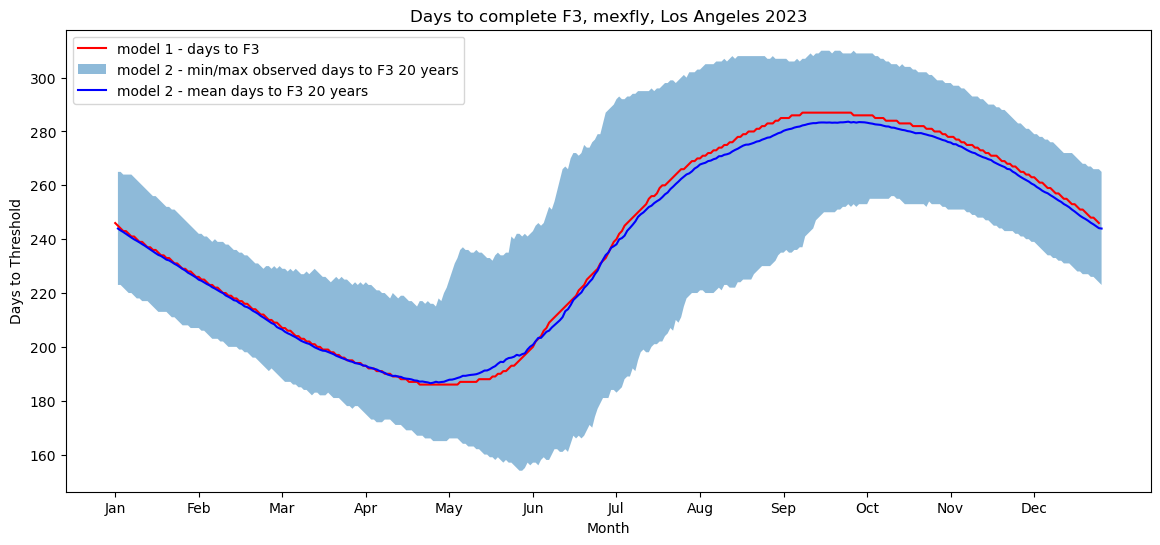

Loading BokehJS ...

: 

In [67]:


#plot the results with month labels
import matplotlib.pyplot as plt
#change plot size
plt.figure(figsize=(14, 6))

plt.plot(results_df['days_to_threshold_mod_1'], color = 'red', label='model 1 - days to F3')
#add mod_2 min and max and shade the area between them
plt.fill_between(results_df['day_of_year'], results_df['mod_2_min'], results_df['mod_2_max'], alpha=0.5, label='model 2 - min/max observed days to F3 20 years')
#add mod_2 mean in red  
plt.plot(results_df['day_of_year'], results_df['mod_2_mean'], color='blue', label='model 2 - mean days to F3 20 years ')

plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#add legend
plt.legend()

plt.xlabel('Month')
plt.ylabel('Days to Threshold')
plt.title('Days to complete F3, mexfly, Los Angeles')
plt.show()

#repeat as interactive plot and hover tool. save to html
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()


downloading recent weather data
Total missing files to download: 0
Number of files modified: 0
loading PRISM data
cropping PRISM data
subsetting dataset by coordinates
masking
mask2
loading PRISM data
calculating degree days
running DD accumulations for historical data, 20 yrs
2000-04-01
2000-04-01
<class 'numpy.datetime64'>
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-06-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
f1 date:  <xarray.DataArray 'gen_comp_date' ()> Size: 8B
array('2000-06-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-08-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
<xarray.DataArray 'degree_days' ()> Size: 8B
array('2000-10-11T00:00:00.000000000', dtype='datetime64[n

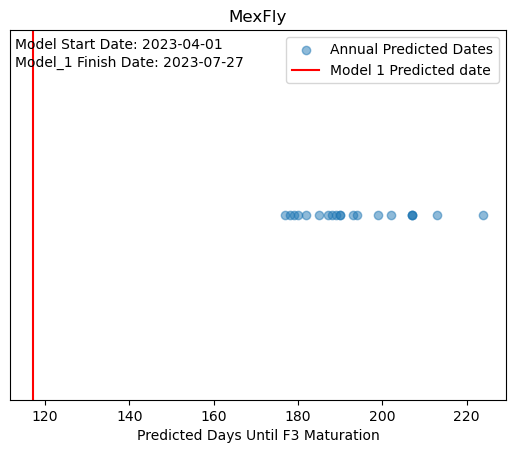

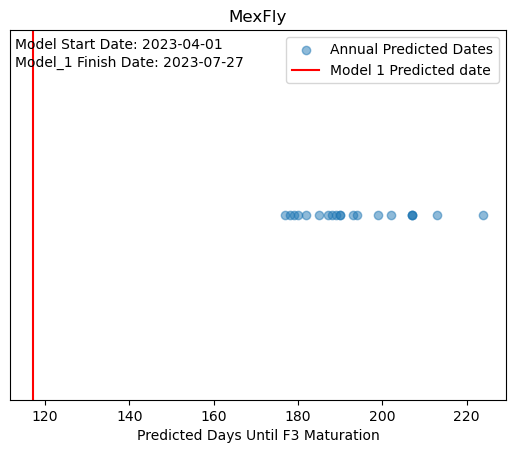

In [2]:
degree_days_data = testing_load_data(data_path, "2000-01-01", 34.05, -118.25, LTT = 9.4, UTT = 999)
dd_accumulations_output = fflies_model_run("2023-04-01", degree_days_data, 34.05, -118.25, LTT = 9.4, UTT = 999, dd_threshold=754, use_current_years_weather= False)
plot_values("2023-07-27", "MexFly",  "2023-04-01", dd_accumulations_output)

In [13]:
DD_Data

<xarray.Dataset> Size: 145kB
Dimensions:      (t: 9064)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
    longitude    float64 8B -118.2
    latitude     float64 8B 34.04
Data variables:
    degree_days  (t) float64 73kB 1.15 1.558 2.521 3.852 ... 12.85 13.26 12.99
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [16]:
dd_t = DD_Data.to_dataarray(dim = "degree_days")

In [18]:
DD_Data

<xarray.Dataset> Size: 145kB
Dimensions:      (t: 9064)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
    longitude    float64 8B -118.2
    latitude     float64 8B 34.04
Data variables:
    degree_days  (t) float64 73kB 1.15 1.558 2.521 3.852 ... 12.85 13.26 12.99
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

[223, 232, 232, 205, 233, 222, 165, 207, 174, 203, 232, 242, 183, 201, 169, 155, 173, 163, 162, 176]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 6_000 draw iterations (4_000 + 24_000 draws total) took 36 seconds.


          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     200.168  5.672   188.842    211.045      0.038    0.027   21821.0   
sigma   26.153  3.354    19.940     32.825      0.023    0.017   21084.0   

       ess_tail  r_hat  
mu      16148.0    1.0  
sigma   17362.0    1.0  
mu: mean = 200, 95% HDI = [188, 211]
sigma: mean = 26, 95% HDI = [19, 32]
95% of the values are lower than: 209


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

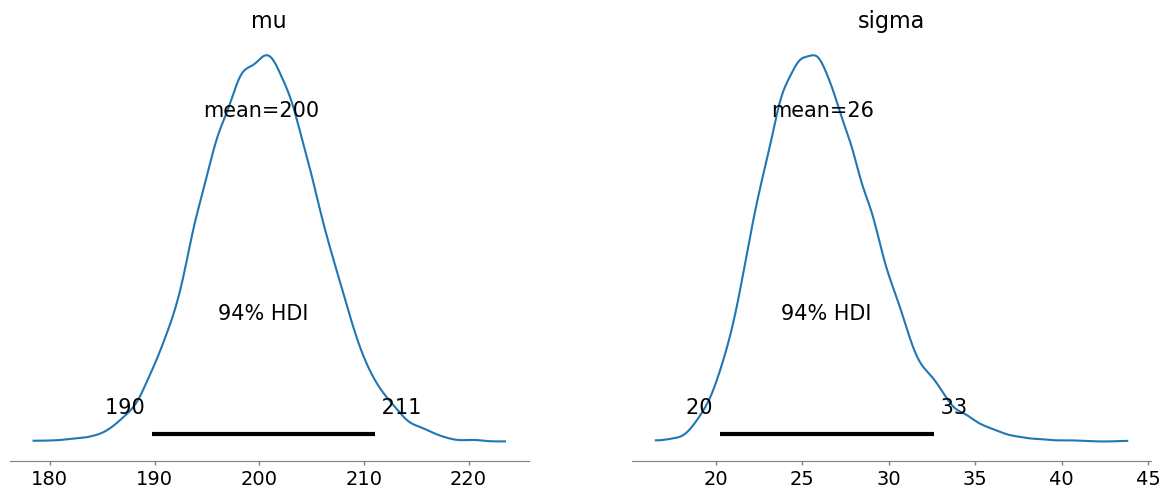

In [18]:

import arviz as az
import pymc as pm
dates = dd_accumulations_output['timedelta'].data.tolist()
print(dates)
# Model
with pm.Model() as model:
    # Priors
    mu = pm.Normal("mu", mu=230, sigma=20)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=dates)

    # Inference
    trace = pm.sample(6000, return_inferencedata=True, cores=4)

# Summarize results
summary = az.summary(trace, hdi_prob=0.95)

print(az.summary(trace, hdi_prob=0.95))

# Extract the mean and 95% HDI and convert them to integers
mean_mu = int(summary.loc['mu', 'mean'])
hdi_95_mu = summary.loc['mu', ['hdi_2.5%', 'hdi_97.5%']].astype(int).tolist()

mean_sigma = int(summary.loc['sigma', 'mean'])
hdi_95_sigma = summary.loc['sigma', ['hdi_2.5%', 'hdi_97.5%']].astype(int).tolist()

# Print the results
print(f"mu: mean = {mean_mu}, 95% HDI = {hdi_95_mu}")
print(f"sigma: mean = {mean_sigma}, 95% HDI = {hdi_95_sigma}")
# Plot posterior distributions

mu_trace = trace.posterior['mu'].values.flatten()

# Calculate the 95th percentile
mu_95_percentile = np.quantile(mu_trace, 0.95)

# Convert to integer
mu_95_percentile = int(mu_95_percentile)

# Print the result
print(f"95% of the values are lower than: {mu_95_percentile}")
az.plot_posterior(trace)

In [28]:
import numpy as np
import pymc as pm

# Assuming dates is your list of numerical values
dates = np.array(dates)  # Convert list to numpy array

with pm.Model() as model:
    # Priors
    mu = pm.Normal("mu", mu=np.mean(dates), sigma=np.std(dates))
    sigma = pm.HalfNormal("sigma", sigma=np.std(dates))

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=dates)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True, cores=2)

    # Posterior predictive check
    ppc = pm.sample_posterior_predictive(trace, var_names=["mu", "sigma"])

# Calculate the 95th percentile of the posterior predictive distribution
ppc_95_percentile = np.percentile(ppc["observed_data"], 95)

# Print the result
print(f"95% of future observations are expected to be lower than: {ppc_95_percentile}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [mu, sigma]


Output()

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

In [44]:
ppc_samples = ppc["posterior_predictive"].values

# Calculate the 95th percentile of the posterior predictive distribution
ppc_95_percentile = np.percentile(ppc_samples['mu'], 95)

# Print the result
print(f"95% of future observations are expected to be lower than: {ppc_95_percentile}")

TypeError: 'method' object is not subscriptable

In [51]:
ppc_result = ppc_samples()
ppc_result['mu'].values

TypeError: 'ValuesView' object is not subscriptable

In [53]:
ppc_samples = np.array(list(ppc_samples["likelihood"].values))

TypeError: 'method' object is not subscriptable

NameError: name 'datetime' is not defined

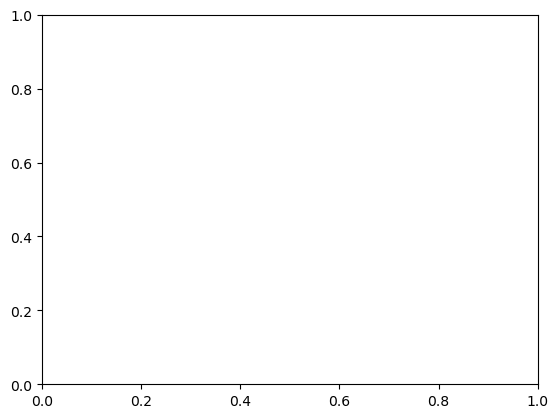

In [56]:
import matplotlib.pyplot as plt

def plot_values(model_1_date, species_name, model_start_date, model_output):
    # Create a figure and axis
    fig, ax = plt.subplots()
    values = model_output['timedelta'].data.tolist()
    model_1_day = days_between(model_start_date, model_1_date)
    # Plot the values as dots
    ax.scatter(values, [0]*len(values), alpha=0.5, label = "Annual Predicted Dates")
    ax.set_xlabel("Predicted Days Until F3 Maturation")

    # Plot the additional value in red
    ax.axvline(x=model_1_day, color='red',label='Model 1 Predicted date' )

    ax.legend()

    # Hide the Y axis
    ax.yaxis.set_visible(False)
    ax.set_title(species_name)

    ax.text(0.01, 0.95, f"Model Start Date: {model_start_date}", transform=ax.transAxes)
    ax.text(0.01, 0.90, f"Model_1 Finish Date: {model_1_date}", transform=ax.transAxes)
    # Show the plot
    plt.show()

# Example usage:


plot_values("2023-12-12", "MexFly",  "2023-06-01", dd_accumulations_output)

In [42]:
from datetime import datetime


# Example usage:
start_date = "2023-06-01"
end_date = "2023-10-15"
print(days_between(start_date, "2023-12-12"))  # Outputs: 30

194


In [17]:
model_start_date = "2024-09-05"
lat = 34.05
lon = -118.25
LTT = 12
UTT = 36

'''
check_and_download_missing_files(model_start_date, data_path)
prism_year_stack = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
)
print(type(prism_year_stack))
# split off data after start date into separate xarray
prism_year_stack, na_mask = subset_dataset_by_coords(prism_year_stack, lat, lon, None)
print("subset")
degree_day_data = da_calculate_degree_days(LTT, UTT, prism_year_stack)
print("calculated dd")
prism_year_stack.close()
'''
degree_day_data_current = degree_day_data.sel(t=slice(model_start_date, None))
####################################################################
# compute the threshold reached date for every year in the historical past and add to an array

# create start day that strips the year from the start date
start_day_str = model_start_date[5:]
print(start_day_str)
##############
# FOR LOOP STARTS HERE
##############
year = 2000

number_days_recent_data = len(degree_day_data_current.t) - 1

start_day_loop = np.datetime64(str(year) + "-" + start_day_str)
finish_day_loop = start_day_loop + np.timedelta64(number_days_recent_data, "D")

start_dates_array = create_start_date_array(degree_day_data, start_day_loop)
temporary_degree_day_data = degree_day_data.sel(t=slice(start_day_loop, None)).copy()


# replace the first n values of the temporary degree day data with the current degree day data
# where n is the length of the current degree day data

print(start_day_loop)
print(finish_day_loop)

temporary_degree_day_data.loc[{"t": slice(start_day_loop, finish_day_loop)}] = (
    degree_day_data_current.values
)

f3_maturation = calculate_f3_maturation_date(temporary_degree_day_data, start_day_loop, 300)
#to the f_3_dates_array add the f3_timedelta as a separate value
# Convert the 'gen_comp_date' to datetime
# Convert the 'gen_comp_date' to datetime
f3_maturation = f3_maturation.to_dataset(name="gen_comp_date")
# Convert the numpy ndarray to a pandas Series
 
f3_maturation['timedelta'] = (f3_maturation['gen_comp_date'].data - start_day_loop) / (24 * 60 * 60 * 1e9)


09-05
2000-09-05
2000-10-07
<class 'numpy.datetime64'>


In [14]:
f3_maturation['gen_comp_date'].data - np.datetime64('2000-01-10')

numpy.timedelta64(38102400000000000,'ns')

#show data keys for f3_maturation
f3_maturation['gen_comp_date']

In [4]:
prism_year_stack_base = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
    engine="h5netcdf",
)
la_window_modified, la_window_mask_modified = subset_dataset_by_coords(
    prism_year_stack_base, 34.05, -118.25, 0.25
)

In [2]:
import xarray as xr
#ALTERNATE io method
data_path = "/media/thom/Q/data/"


def get_sample_indicies(lat, lon, window):
    # gets sample indicies for a file from jan 1 2001 - could be changed? probably not

    master_file = xr.open_dataset(data_path + "PRISM/2001/PRISM_combo_20010101.nc")
    lat_min, lat_max = lat - window, lat + window
    lon_min, lon_max = lon - window, lon + window
    lat_indices = (master_file.latitude >= lat_min) & (master_file.latitude <= lat_max)
    lon_indices = (master_file.longitude >= lon_min) & (
        master_file.longitude <= lon_max
    )
    return lat_indices, lon_indices


lat_indices, lon_indices = get_sample_indicies(34.05, -118.25, 0.25)


# Step 2: Use the indices to read only the required data from other files
def subset_by_indices(ds, lat_indices, lon_indices):
    """Subset the dataset using pre-calculated indices."""
    return ds.isel(latitude=lat_indices, longitude=lon_indices)


# Use the indices when loading multiple files
prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    # chunks={"latitude": 1000, "longitude": 1000},
    drop_variables=["ppt", "tmean"],
    engine="h5netcdf",
    # parallel=True,
    preprocess=lambda ds: subset_by_indices(ds, lat_indices, lon_indices),
)

In [3]:
# Step 1: Open a master file to get the subset indices
master_file = xr.open_dataset(data_path + "PRISM/2001/PRISM_combo_20010101.nc")

# Define your region of interest (latitude/longitude)
lat_min, lat_max = 34.05 - 0.25, 34.05 + 0.25
lon_min, lon_max = -118.25 - 0.25, -118.25 + 0.25

# Get the indices of the latitude/longitude range
lat_indices = (master_file.latitude >= lat_min) & (master_file.latitude <= lat_max)
lon_indices = (master_file.longitude >= lon_min) & (master_file.longitude <= lon_max)


# Step 2: Define the map function to read and subset each file
def map_function(file_path, lat_indices, lon_indices):
    ds = xr.open_dataset(file_path)
    subset = ds.isel(latitude=lat_indices, longitude=lon_indices)
    return subset


# List of file paths to process (PRISM files for example)
file_list = sorted(glob.glob(data_path + "PRISM/*/PRISM_combo_*.nc"))

# Step 3: Use Dask to map the function across all files in parallel
mapped_results = [
    dask.delayed(map_function)(file, lat_indices, lon_indices) for file in file_list
]

# Step 4: Reduce: Combine the mapped results into a single xarray dataset
combined_result = xr.concat(dask.compute(*mapped_results), dim="t")

# Now you have the combi

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5A.c line 1891 in H5Aiterate2(): invalid location identifier
    major: Invalid arguments to routine
    minor: Inappropriate type
  #001: H5VLint.c line 1741 in H5VL_vol_object(): invalid identifier type to function
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5A.c line 1891 in H5Aiterate2(): invalid location identifier
    major: Invalid arguments to routine
    minor: Inappropriate type
  #001: H5VLint.c line 1741 in H5VL_vol_object(): invalid identifier type to function
    major: Invalid arguments to routine
    minor: Inappropriate type
2024-09-23 15:42:29,724 - distributed.worker - WARNING - Compute Failed
Key:       map_function-fee7666f-f4f6-444c-9b36-2a6d7bf8daff
State:     executing
Function:  map_function
args:      ('/media/thom/Q/data/PRISM/2009/PRISM_combo_20090102.nc', <xarray.DataArray 'latitude' (latitude: 621)> Size: 621

2024-09-23 15:42:29,870 - distributed.nanny - WARNING - Restarting worker


RuntimeError: NetCDF: Can't open HDF5 attribute

In [6]:
combined_result

<xarray.Dataset> Size: 946kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    ppt        (t, latitude, longitude) float64 236kB 0.93 1.03 1.18 ... 0.0 0.0
    tmean      (t, latitude, longitude) float64 236kB 7.846 7.858 ... 13.1 13.28
    tmin       (t, latitude, longitude) float64 236kB 4.583 4.72 ... 6.58 6.789
    tmax       (t, latitude, longitude) float64 236kB 11.11 11.0 ... 19.62 19.77
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [12]:
prism_year_stack_modified

<xarray.Dataset> Size: 474kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    tmin       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
    tmax       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [10]:
prism_year_stack_modified

<xarray.Dataset> Size: 474kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    tmin       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
    tmax       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

# Define a preprocessing function to subset coordinates
def subset_coords(ds, lat_min, lat_max, lon_min, lon_max):
    """Subset the dataset by lat/lon bounds, automatically adjusting to file's bounds."""

    # Get the actual lat/lon bounds in the dataset
    lat_actual_min = ds.latitude.min().values
    lat_actual_max = ds.latitude.max().values
    lon_actual_min = ds.longitude.min().values
    lon_actual_max = ds.longitude.max().values

    # Clip the requested bounds to the available bounds
    lat_min_clipped = max(lat_min, lat_actual_min)
    lat_max_clipped = min(lat_max, lat_actual_max)
    lon_min_clipped = max(lon_min, lon_actual_min)
    lon_max_clipped = min(lon_max, lon_actual_max)

    # Subset the dataset using the clipped bounds
    return ds.sel(
        latitude=slice(lat_min_clipped, lat_max_clipped),
        longitude=slice(lon_min_clipped, lon_max_clipped),
    )

# Define your bounding box
lat_min, lat_max = 39.05 - 0.25, 39.05 + 0.25
lon_min, lon_max = -96.25 - 0.25, -96.25 + 0.25

# Apply preprocessing to only load the subset of data you're interested in
prism_year_stack_modified_2 = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    #chunks={"latitude": 100, "longitude": 100},
    combine="nested",
    drop_variables=["ppt", "tmean"],
    #join = "override",
    preprocess=lambda ds: subset_coords(ds, lat_min, lat_max, lon_min, lon_max),
)

In [36]:
prism_year_stack_modified_2.compute()

<xarray.Dataset> Size: 2kB
Dimensions:    (t: 205, longitude: 12, latitude: 0)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -96.5 -96.46 -96.42 ... -96.08 -96.04
  * latitude   (latitude) float64 0B 
Data variables:
    tmin       (t, latitude, longitude) float64 0B 
    tmax       (t, latitude, longitude) float64 0B 
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [28]:
sample_file = xr.open_dataset(data_path + "PRISM/2000/PRISM_combo_20000101.nc")
print(sample_file.latitude.values)
print(sample_file.longitude.values)

[49.91666667 49.875      49.83333333 49.79166667 49.75       49.70833333
 49.66666667 49.625      49.58333333 49.54166667 49.5        49.45833333
 49.41666667 49.375      49.33333333 49.29166667 49.25       49.20833333
 49.16666667 49.125      49.08333333 49.04166667 49.         48.95833333
 48.91666667 48.875      48.83333333 48.79166667 48.75       48.70833333
 48.66666667 48.625      48.58333333 48.54166667 48.5        48.45833333
 48.41666667 48.375      48.33333333 48.29166667 48.25       48.20833333
 48.16666667 48.125      48.08333333 48.04166667 48.         47.95833333
 47.91666667 47.875      47.83333333 47.79166667 47.75       47.70833333
 47.66666667 47.625      47.58333333 47.54166667 47.5        47.45833333
 47.41666667 47.375      47.33333333 47.29166667 47.25       47.20833333
 47.16666667 47.125      47.08333333 47.04166667 47.         46.95833333
 46.91666667 46.875      46.83333333 46.79166667 46.75       46.70833333
 46.66666667 46.625      46.58333333 46.54166667 46

In [2]:
import xarray as xr
import datetime
from dask.distributed import Client
import time
from functools import partial

data_path = "data/test/"


def subset_dataset_by_coords(dataset, lat, lon, window_size=None):
    if window_size is not None:
        # Define the window boundaries
        lat_min = lat - window_size
        lat_max = lat + window_size
        lon_min = lon - window_size
        lon_max = lon + window_size

        # Create boolean masks for the coordinate ranges
        mask_lat = (dataset.latitude >= lat_min) & (dataset.latitude <= lat_max)
        mask_lon = (dataset.longitude >= lon_min) & (dataset.longitude <= lon_max)

        # Apply the mask using .where() and drop the data points outside the window
        subset = dataset.where(mask_lat & mask_lon, drop=True)
        return subset
    else:
        subset = dataset.sel(latitude=lat, longitude=lon, method="nearest")
        return subset


# Check if client is already running
client = Client(n_workers=2, threads_per_worker=2, memory_limit="2GB")
client

# Define the latitude, longitude, and window size
lat = 34.05
lon = -118.25
window_size = 0.25

# Start timer
start_2 = datetime.datetime.now()

# Load and subset the dataset with chunks
prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    chunks={"latitude": 50, "longitude": 1000},
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
    preprocess=lambda ds: subset_dataset_by_coords(ds, lat, lon, window_size),
)

# Stop timer
end_2 = datetime.datetime.now()
print(f"Time elapsed: {end_2 - start_2}")

# Measure time for la_window_modified.compute()
start_time = time.time()
la_windown = prism_year_stack_modified.compute()
end_time = time.time()
print(f"Time taken for la_window_modified.compute(): {end_time - start_time} seconds")

/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37251 instead
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks sep

Time elapsed: 0:00:09.761760
Time taken for la_window_modified.compute(): 9.267749547958374 seconds


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
from dask import delayed, compute


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold):
    """
    Calculate the date when the threshold is reached for the third time
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    return threshold_reached_days_f3


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    for year in range(start_year, end_year):
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(calculate_f3_maturation_date(dd_data, year_start_date, threshold))

    return tasks


tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = compute(*tasks)

[Delayed('calculate_f3_maturation_date-72af83b3-1e68-4303-936a-3f895dc91ec0'),
 Delayed('calculate_f3_maturation_date-308b6bb2-6057-46bf-af55-9b16e09625bd'),
 Delayed('calculate_f3_maturation_date-4ce3f45a-5789-4ec2-99f1-58e68f2a276a'),
 Delayed('calculate_f3_maturation_date-b1631eb7-f721-41bd-8bff-cc1c840b1b90'),
 Delayed('calculate_f3_maturation_date-c0ba7907-66db-49a7-8e1b-c5636460a5bc'),
 Delayed('calculate_f3_maturation_date-b81b4b51-8755-4f27-b3b0-0ca07b38b332'),
 Delayed('calculate_f3_maturation_date-2f6698bf-e8d0-4914-a11e-ee2e29095df4'),
 Delayed('calculate_f3_maturation_date-fa17ed48-2cf4-4a71-a903-0e767d579fe6'),
 Delayed('calculate_f3_maturation_date-4097d16a-aa2b-460e-8a0d-b9a77dae729c'),
 Delayed('calculate_f3_maturation_date-b9ba045f-85f6-4afb-92f5-c025f707957f'),
 Delayed('calculate_f3_maturation_date-01173d7d-7dbe-48e3-a6a3-bf2b830dbe0a'),
 Delayed('calculate_f3_maturation_date-72b8bb28-bed4-470c-b056-f72ab19afab4'),
 Delayed('calculate_f3_maturation_date-c984b6c3-b8be

In [54]:
import xarray as xr
import datetime
from dask import delayed, compute
import numpy as np


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold, year):
    """
    Calculate the date when the threshold is reached for the third time
    and the timedelta in days from the start date
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    # suppress warnings for the following line
    warnings.filterwarnings("ignore")

    maturation_date = threshold_reached_days_f3
    timedelta_days = (
        (maturation_date - np.datetime64(start_date))
        .astype("timedelta64[D]")
        .astype(int)
    )
    timedelta_days = timedelta_days / (86400 * 10**9)
    if year == 2000:
        print(timedelta_days)
    warnings.filterwarnings("default")
    timedelta_days = np.where(timedelta_days < 0, np.nan, timedelta_days)

    return maturation_date, timedelta_days


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    years = list(range(start_year, end_year))
    for year in years:
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(
            calculate_f3_maturation_date(dd_data, year_start_date, threshold, year)
        )

    # Compute the results
    results = compute(*tasks)

    # Separate the results into two arrays
    maturation_dates = np.array([result[0] for result in results])
    timedelta_days = np.array([result[1] for result in results])

    # Create a 3D xarray DataArray with an additional layer for timedelta in days
    data_array = xr.Dataset(
        {
            "f3_maturation_dates": (
                ["year", "latitude", "longitude"],
                maturation_dates,
            ),
            "timedelta_days": (["year", "latitude", "longitude"], timedelta_days),
        },
        coords={
            "year": years,
            "latitude": dd_data.latitude,
            "longitude": dd_data.longitude,
        },
    )

    return data_array


# Example usage
tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = tasks

<xarray.DataArray 'gen_comp_date' (latitude: 12, longitude: 12)> Size: 1kB
array([[ 3.67000000e+02,  3.67000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.69000000e+02,
         3.70000000e+02,  3.70000000e+02,  3.73000000e+02,
         1.09900000e+03,  7.40000000e+02,  1.09900000e+03],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.69000000e+02,  3.72000000e+02,  3.70000000e+02,
         1.09900000e+03,  1.09900000e+03,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.69000000e+02,  3.73000000e+02,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e

/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


In [49]:
import xarray as xr
import numpy as np

# Create a 10x10 array filled with the datetime 2000-01-05
lat = np.arange(10)
lon = np.arange(10)
date = np.datetime64("2000-01-05")

data = np.full((10, 10), date)

# Create the xarray DataArray
data_array = xr.DataArray(
    data, coords={"latitude": lat, "longitude": lon}, dims=["latitude", "longitude"]
)

# Calculate the timedelta in days from 2000-01-01
start_date = np.datetime64("2000-01-01")
timedelta_days = (data_array - start_date).astype("timedelta64[D]").astype(int)

print("Original DataArray:")
print(data_array)
print("\nTimedelta in days from 2000-01-01:")
print(timedelta_days)


Original DataArray:
<xarray.DataArray (latitude: 10, longitude: 10)> Size: 800B
array([['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.0

/tmp/ipykernel_91163/3599759843.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_array = xr.DataArray(
/tmp/ipykernel_91163/3599759843.py:18: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision

AttributeError: 'DataArray' object has no attribute 'datetime'

In [44]:
df = degree_days.to_dask_dataframe()

In [49]:
df["time"].values.compute()

array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ...,
       '2000-02-17T00:00:00.000000000', '2000-02-18T00:00:00.000000000',
       '2000-02-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
result

<xarray.DataArray 'random_sample-0deae3d2b57b3970034734ef19a7c8c2' (lat: 10,
                                                                    lon: 10)> Size: 800B
array([[9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17]])
Coordinates:
  * lat      (lat) float64 80B -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
  * lon      (lon) float64 80B -180.0 -140.0 -100.0 -60.0 ... 100.0 140.0 180.0